#사용법

1. 우측 상단 '로그인'

2. 좌측 상단 '실습 모드에서 열기' 또는 'Drive에 사본 저장'

※ 각각의 셀은 셀 좌측 상단 실행 버튼을 통해 실행할 수 있습니다.

※ 혹은 CTRL + ENTER로 실행 가능합니다.

※ 실행 중 '경고: 이 노트는 Google에서 작성하지 않았습니다.'라는 창이 뜰 경우, '실행 전에 모든 런타임 재설정'란에 체크 후 '무시하고 계속하기'를 하시면 됩니다.

# 텍스트 임베딩 모델 테스트

In [2]:
from sentence_transformers import SentenceTransformer

# 모델을 로드합니다.
model = SentenceTransformer('Qwen/Qwen3-Embedding-0.6B')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/727 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.19G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/313 [00:00<?, ?B/s]

In [7]:
# 텍스트를 텍스트 임베딩으로 변환합니다.
vector1 = model.encode("Best movie ever!")
vector2 = model.encode("Worst movie ever!")
vector3 = model.encode("I don't like movie.")

In [25]:
vector1.shape

(1024,)

In [9]:
# vector끼리의 유사도
from sklearn.metrics.pairwise import cosine_similarity

print(cosine_similarity([vector1], [vector2]))
print(cosine_similarity([vector1], [vector3]))
print(cosine_similarity([vector2], [vector3]))

[[0.79975784]]
[[0.5487937]]
[[0.6552938]]


# 임베딩으로 노래 추천하기

노래를 단어나 토큰으로 생각하고 재생목록을 문장처럼 생각해봅시다.

- 재생목록1: 노래1, 노래13, 노래79, ...
- 재생목록2: 노래3, 노래2, 노래82, ...

그다음 임베딩 기법을 사용해서 재생목록을 학습시킨다면 자주 함께 등장하는 비슷한 노래를 추천할 수 있습니다.

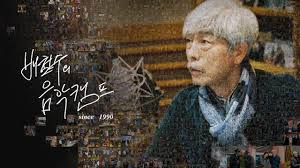

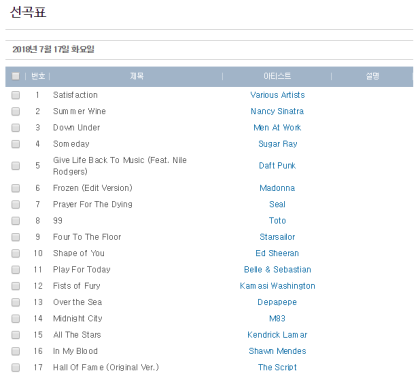

- 라디오 방송국 노래 재생목록 데이터셋

( December 2010 to May 2011. This lead to a dataset of 75,262 songs and 2,840,553 transitions.)

https://www.cs.cornell.edu/~shuochen/lme/data_page.html

In [29]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.6/26.6 MB 36.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 49.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 9.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.1
    Uninstalling scipy-1.16.1:
      Successfully uninstalled scipy-1.16.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<

In [2]:
import pandas as pd
from urllib import request

# 재생목록 데이터셋 파일을 가져옵니다.
data = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/train.txt')

# 재생목록 파일을 파싱합니다. 처음 두 줄은 메타데이터만 담고 있으므로 건너뜁니다.
lines = data.read().decode("utf-8").split('\n')[2:]

# 하나의 노래만 있는 재생목록은 삭제합니다.
playlists = [s.rstrip().split() for s in lines if len(s.split()) > 1]

# 노래의 메타데이터를 로드합니다.
songs_file = request.urlopen('https://storage.googleapis.com/maps-premium/dataset/yes_complete/song_hash.txt')
songs_file = songs_file.read().decode("utf-8").split('\n')
songs = [s.rstrip().split('\t') for s in songs_file]
songs_df = pd.DataFrame(data=songs, columns = ['id', 'title', 'artist'])
songs_df = songs_df.set_index('id')

In [12]:
len(songs_file)

75263

In [19]:
songs_df

,title,artist
id,,
0,Gucci Time (w\/ Swizz Beatz),Gucci Mane
1,Aston Martin Music (w\/ Drake & Chrisette Mich...,Rick Ross
2,Get Back Up (w\/ Chris Brown),T.I.
3,Hot Toddy (w\/ Jay-Z & Ester Dean),Usher
4,Whip My Hair,Willow
...,...,...
75258,USA Today,Alan Jackson
75259,Superstar,Raul Malo
75260,Romancin' The Blues,Giacomo Gates


In [42]:
# songs_df[songs_df['artist'] == "Michael Jackson"]
songs_df[songs_df['artist'] == "Mariah Carey"]

,title,artist
id,,
125,We Belong Together,Mariah Carey
386,Touch My Body,Mariah Carey
407,One Sweet Day (w\/ Boyz II Men),Mariah Carey
408,Up Out My Face,Mariah Carey
5650,It's Like That (w\/ Jermaine Dupri & Fatman Sc...,Mariah Carey
5726,Don't Forget About Us,Mariah Carey
5772,Obsessed,Mariah Carey
5783,Shake It Off,Mariah Carey
8457,Hero,Mariah Carey


In [3]:
print('재생목록 #1:\n ', playlists[0], '\n')
print('재생목록 #2:\n ', playlists[1])

재생목록 #1:
  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '2', '42', '43', '44', '45', '46', '47', '48', '20', '49', '8', '50', '51', '52', '53', '54', '55', '56', '57', '25', '58', '59', '60', '61', '62', '3', '63', '64', '65', '66', '46', '47', '67', '2', '48', '68', '69', '70', '57', '50', '71', '72', '53', '73', '25', '74', '59', '20', '46', '75', '76', '77', '59', '20', '43'] 

재생목록 #2:
  ['78', '79', '80', '3', '62', '81', '14', '82', '48', '83', '84', '17', '85', '86', '87', '88', '74', '89', '90', '91', '4', '73', '62', '92', '17', '53', '59', '93', '94', '51', '50', '27', '95', '48', '96', '97', '98', '99', '100', '57', '101', '102', '25', '103', '3', '104', '105', '106', '107', '47', '108', '109', '110', '111', '112', '113', '25', '63', '62', '114', '115', '84', '116', '117', '118', 

In [4]:
from gensim.models import Word2Vec

# Word2Vec 모델을 훈련합니다.(시간 소요)
model = Word2Vec(
    playlists, vector_size=32, window=20, negative=50, min_count=1, workers=4
)

In [43]:
song_id = 54054
print(songs_df.iloc[song_id])

title     All I Want For Christmas Is You
artist                       Mariah Carey
Name: 54054 , dtype: object


In [44]:
import numpy as np

def print_recommendations(song_id):
    similar_songs = np.array(
        model.wv.most_similar(positive=str(song_id),topn=10)
    )[:,0]
    return  songs_df.iloc[similar_songs]

# 추천 노래 출력
print(songs_df.iloc[song_id])
print_recommendations(song_id)

title     All I Want For Christmas Is You
artist                       Mariah Carey
Name: 54054 , dtype: object


,title,artist
id,,
54646,Let It Snow! Let It Snow! Let It Snow!,Frank Sinatra
53785,Last Christmas,Wham!
54172,Jingle Bell Rock,Daryl Hall & John Oates
54660,My Favorite Things,Barbra Streisand
54326,Same Old Lang Syne,Dan Fogelberg
54180,Sleigh Ride,Leroy Anderson
54035,Winter Wonderland,Johnny Mathis
54286,Have Yourself A Merry Christmas,Barry Manilow
38108,Rudolph The Red-Nosed Reindeer,Burl Ives


# Word2Vec 직접 학습하기

In [ ]:
# google drive 연동
# 모두 '예' 선택
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/nlp_basic/

/content/drive/MyDrive/nlp_basic


## CBOW 아키텍처

<img src="https://github.com/oglee815/nlp_basic/blob/main/img/CBOW.png?raw=true" width='600'>



<img src="https://github.com/oglee815/nlp_basic/blob/main/img/cbow2.png?raw=true" width='1000'>




In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss


class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size

        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')

        # 계층 생성
        # windows size 1임을 가정하고 in_layer 경로를 2개 만듦
        self.in_layer1 = MatMul(W_in)
        self.in_layer2 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()

        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer1, self.in_layer2, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads

        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in

    def forward(self, contexts, target):
        h0 = self.in_layer1.forward(contexts[:, 0]) # 첫번째 맥락, batch, contexts, vocab_size
        h1 = self.in_layer2.forward(contexts[:, 1]) # 두번째 맥락
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss

    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5 # 2개 단어가 Loss에 대해 관여하였으므로 나누기 2
        self.in_layer1.backward(da)
        self.in_layer2.backward(da)
        return None


## 학습 데이터 수집

word2vec 학습을 위해 원하는 주제의 위키피디아 데이터를 가져옵니다.

In [ ]:
# 필요한 라이브러리 설치
!pip install wikipedia-api
!pip install konlpy

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia-api: filename=Wikipedia_API-0.8.1-py3-none-any.whl size=15383 sha256=cc95b9f330f28b92c7d4627be767bf568fc8975c416caaa7bba46f09b8c1a43a
  Stored in directory: /root/.cache/pip/wheels/0b/0f/39/e8214ec038ccd5aeb8c82b957289f2f3ab2251febeae5c2860
Successfully built wikipedia-api
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.1/494.1 kB 20.8 MB/s eta 0:00:00


In [ ]:
import wikipediaapi
wiki_wiki = wikipediaapi.Wikipedia(user_agent='test-agent', language='ko')

In [ ]:
# 원하는 주제를 선정하세요(위키피디아에 있는 주제)
wiki_data = wiki_wiki.page('박지성')
wiki_data_summary = "제목: " + wiki_data.title + "\n요약: " + wiki_data.summary
print(wiki_data_summary)

print("문서 길이: " + str(len(wiki_data.text)))
print(wiki_data.text)

In [ ]:
# 효율적인 학습을 위해 조사, 어미, 구두점 제거

from konlpy.tag import Okt

# Okt 객체 생성
okt = Okt()

okt_pos = okt.pos(wiki_data.text, norm=True, stem=True)

word_list = []
for word in okt_pos:
    if word[1] not in ['Josa', 'Eomi', 'Punctuation']:
        word_list.append(word[0])

preprocessed_data = ' '.join(word_list)

In [ ]:
preprocessed_data

## 학습시작

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
| 에폭 28 |  반복 341 / 570 | 시간 20[s] | 손실 3.61
| 에폭 28 |  반복 361 / 570 | 시간 20[s] | 손실 3.46
| 에폭 28 |  반복 381 / 570 | 시간 20[s] | 손실 3.29
| 에폭 28 |  반복 401 / 570 | 시간 20[s] | 손실 3.61
| 에폭 28 |  반복 421 / 570 | 시간 20[s] | 손실 3.38
| 에폭 28 |  반복 441 / 570 | 시간 20[s] | 손실 3.75
| 에폭 28 |  반복 461 / 570 | 시간 20[s] | 손실 3.48
| 에폭 28 |  반복 481 / 570 | 시간 20[s] | 손실 3.65
| 에폭 28 |  반복 501 / 570 | 시간 20[s] | 손실 3.60
| 에폭 28 |  반복 521 / 570 | 시간 20[s] | 손실 3.55
| 에폭 28 |  반복 541 / 570 | 시간 20[s] | 손실 3.64
| 에폭 28 |  반복 561 / 570 | 시간 20[s] | 손실 3.44
| 에폭 29 |  반복 1 / 570 | 시간 20[s] | 손실 3.56
| 에폭 29 |  반복 21 / 570 | 시간 20[s] | 손실 2.97
| 에폭 29 |  반복 41 / 570 | 시간 20[s] | 손실 3.03
| 에폭 29 |  반복 61 / 570 | 시간 20[s] | 손실 3.21
| 에폭 29 |  반복 81 / 570 | 시간 20[s] | 손실 3.06
| 에폭 29 |  반복 101 / 570 | 시간 20[s] | 손실 3.14
| 에폭 29 |  반복 121 / 570 | 시간 20[s] | 손실 3.16
| 에폭 29 |  반복 141 / 570 | 시간 20[s] | 손실 3.22
| 에폭 29 |  반복 161 / 570 | 시간 20[s] | 손실 3.31
| 에폭 29 |  반복 181 / 570 |

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48373 (\N{HANGUL SYLLABLE BOG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49552 (\N{HANGUL SYLLABLE SON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


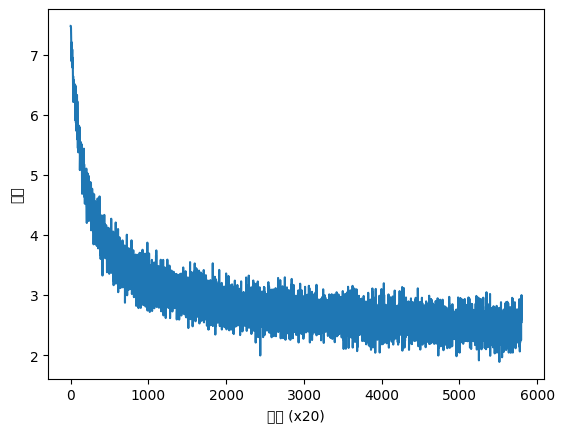

In [ ]:
# coding: utf-8
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 10
max_epoch = 200
lr=0.01

text = preprocessed_data

# 조사 등이 제거 된 데이터를 기준으로
# 공백 기준으로 분할하여 Vocabulary를 생성함
# corpus: 텍스트 내 모든 단어 ID 시퀀스
# word_to_id: 단어를 ID로 변환하는 딕셔너리, 예시: {'박지성': 1, '히딩크': 2}
# id_to_word: ID를 단어로 변환하는 딕셔너리, 예시: {1: '박지성', 2: '히딩크'}
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size) # 중간 단어와 맥락 단어 데이터 생성
target = convert_one_hot(target, vocab_size) # 타겟 데이터를 one-hot encoding으로 변환, 박지성 = [1, 0, 0, 0, ...]
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam(lr=lr)
trainer = Trainer(model, optimizer)

# 학습 시작
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [ ]:
# 학습이 완료된 후 벡터의 모습을 확인합니다.
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

박지성 [-0.37066054 -0.78443533  1.3291068  -1.2313032  -0.12379938]
1981년 [  3.9919958   -0.33113763  -0.89150375  -8.841565   -23.042694  ]
2월 [  7.3527055 -13.041211   -0.8654868  -1.164295   -5.780808 ]
25일 [ -6.7669396 -16.354458   -0.6298817 -15.035025    4.4232187]
은 [ 1.371627   -2.6870177   0.8450019  -2.1488266  -0.97079325]
대한민국 [-2.0523088 -1.6140627  0.8785475 -1.3585522  1.0739005]
은퇴 [-3.8508646 -1.8637052  0.4500339 -1.2647607  2.256299 ]
프로 [-0.8647114  -1.1700394   0.22936389  0.121357    1.3352773 ]
축구 [-5.8195844  -4.0564013  -0.38989902  1.1483287   0.28139195]
선수 [-1.6704557  -3.1306775  -0.59419596 -1.6243994   0.672186  ]
현역 [-4.373963   -0.41858652  2.9590683  -1.4531109   1.46636   ]
시절 [-0.41243953 -1.8513634  -0.7091324  -2.933804    1.6183168 ]
포지션 [ 2.5065432   3.0102465   0.09766158 -4.359656   -1.4364902 ]
윙어 [ 0.62609035  1.7592517  -1.7625686  -2.172261   -0.4572009 ]
미드필더 [ 1.7586935   1.1901249  -0.28513795 -0.8520651   1.4854459 ]
현재 [ 1.2472965 -0.511

## 평가

학습이 잘 됐는지 평가하기 위해, 유사한 단어들을 찾아보세요

In [ ]:
from common.util import most_similar

# 가장 비슷한(most similar) 단어 뽑기
querys = ['박지성', '히딩크', '맨유']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=10)


[query] 박지성
 그리고: 0.9822012186050415
 주다: 0.9673401117324829
 2000~2003: 0.9627329707145691
 함께: 0.9591667056083679
 2002년: 0.950745165348053
 확정: 0.9405885934829712
 위키인용집: 0.9201222658157349
 에레디비시: 0.9195919632911682
 방송: 0.9044495224952698
 맨체스터: 0.9038324952125549

[query] 히딩크
 공격수: 0.9803759455680847
 공: 0.9728412628173828
 중학교: 0.9316425919532776
 격인: 0.9299907684326172
 수립: 0.9211708903312683
 를: 0.9052500128746033
 통합: 0.8994854688644409
 –: 0.8946914672851562
 인종차별: 0.8934947848320007
 추억: 0.8897465467453003

[query] 맨유
 라이언: 0.97422856092453
 유나이티드: 0.9528160095214844
 얻다: 0.9362369775772095
 포지션: 0.9235888123512268
 라운드: 0.9114948511123657
 205: 0.9075900912284851
 에는: 0.9068073034286499
 온: 0.8984624147415161
 강전: 0.8889843225479126
 리거: 0.8693252801895142


## 추가 문제

1. windows size를 1이 아니라 2로 늘려보세요.